In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import pickle
import os

import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm
import mapping_sc_to_st

In [23]:
import sys, importlib

for k in list(sys.modules.keys()):
    if k == "mapping_sc_to_st" or k.startswith("mapping_sc_to_st"):
        del sys.modules[k]

import mapping_sc_to_st

# Data Import

In [3]:
use_sc_data = 'sc' # 'sc' or 'mc'

exclude_st_cell_region = ['YSL', 'Dorsal Forerunner Cells', 'Primordial Germ Cells']

## file path
path_st = '/local/users/mmittnenzweig/spatiotemporal_zebrafish/data/weMerfish/AnnData_withImputation/'
path_mc = '/local/users/dlee/ST/data/timecourse_wt/timecourse_wt.metacells_celltypes-distance-2025-11-19.h5ad'
path_sc = "/local/users/dlee/ST/data/timecourse_wt/make_small_clusters_10_3_100.h5ad"
metacell_graph = '/local/users/dlee/ST/data/cell_type_mgraph.csv'
cell_color_path = '/local/users/dlee/ST/data/cell_type_colors-2025-11-19.csv'

cell_type_color = pd.read_csv(cell_color_path)

In [4]:
adata_sc = sc.read_h5ad(path_sc)
adata_mc = sc.read_h5ad(path_mc)
adata_st = sc.read_h5ad(path_st + 'B_75p_E1_with_imputation.h5ad')

In [5]:
st_mask = ~adata_st.obs["clusters"].isin(exclude_st_cell_region)
adata_st = adata_st[st_mask, :].copy()

In [6]:
adata_sc, _ = mapping_sc_to_st.prep.filter_small_celltypes(
    adata_sc,
    groupby="cell_type",
    min_cells=2,
)

too small groups: []


In [7]:
if use_sc_data == 'mc':
    _ = mapping_sc_to_st.prep.ensure_all_basic(
        adata_sc,
        adata_st,
        make_spatial_normed=True,   
        spatial_k=10,
        
        make_scvi=False,
        
        make_scvi_st=True,         
        scvi_st_batch_key=None,     
        scvi_st_n_latent=64,
        scvi_st_max_epochs=200,
        scvi_st_counts_layer="counts",
        st_latent_key="X_scvi",
        model_device = 'gpu',
        accelerator = 'gpu',
        devices = [2]
    )

else:
    _ = mapping_sc_to_st.prep.ensure_all_basic(
        adata_sc,
        adata_st,
        st_xy_cols=None,     

        make_spatial_normed=True,   
        spatial_k=10,

        make_scvi=True,            
        scvi_batch_key=None,    
        scvi_counts_layer="counts", 
        scvi_n_latent=20,
        scvi_max_epochs=100,

        make_scvi_st=True,         
        scvi_st_batch_key=None,     
        scvi_st_n_latent=20,
        scvi_st_max_epochs=100,
        scvi_st_counts_layer="counts",
        st_latent_key="X_scvi",
        model_device = 'gpu',
        accelerator = 'gpu',
        devices = [2]
    )

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.


start make_scvi


You are using a CUDA device ('NVIDIA A16') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 100/100: 100%|██████████| 100/100 [02:30<00:00,  1.52s/it, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=1.02e+3]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|██████████| 100/100 [02:30<00:00,  1.51s/it, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=1.02e+3]


In [8]:
common_gene = adata_st.var_names.intersection(adata_sc.var_names)
adata_sc = adata_sc[:, common_gene].copy()
adata_st = adata_st[:, common_gene].copy()

adata_mc.obsm['X_umap'] = adata_mc.obs[['x', 'y']].to_numpy()

all_cell_types = adata_sc.obs["cell_type"].astype(str).unique()
mask = adata_mc.obs["cell_type"].astype(str).isin(all_cell_types).to_numpy()

#mask = list(adata_sc.obs['metacell_name'].unique())
#mask = list(set(adata_mc.obs.index) & set(mask))

#mask = list(set(adata_mc.obs.index))

if use_sc_data == 'mc': 
    adata_sc = adata_mc
    _ = mapping_sc_to_st.prep.ensure_all_basic(
        adata_sc,
        adata_st,
        st_xy_cols=None,     

        make_spatial_normed=True,   
        spatial_k=10,

        make_scvi=True,            
        scvi_batch_key=None,    
        scvi_counts_layer="total_umis", 
        scvi_n_latent=512,
        scvi_max_epochs=200,
        model_device = 'gpu',
        accelerator = 'gpu',
        devices = [2],
        
        make_scvi_st=False,   
    )
    
    adata_sc = adata_sc[mask, common_gene].copy()

In [9]:
if use_sc_data == 'mc':
    hvg_layer = 'total_umis'
else:
    hvg_layer = 'counts'

selected_genes, deg_results, hvg_results = mapping_sc_to_st.genes.select_genes_per_celltype(
                                                                    adata_sc,
                                                                    groupby="cell_type",
                                                                    
                                                                    # DEG parameters
                                                                    deg_method="wilcoxon",
                                                                    deg_n_genes=None,
                                                                    deg_pval_cutoff=0.1,
                                                                    deg_logfc_cutoff=1.5,
                                                                    
                                                                    # HVG parameters
                                                                    hvg_n_top_genes=40,
                                                                    hvg_flavor="seurat_v3",
                                                                    hvg_layer=None,
                                                                    # Gene selection rule
                                                                    mode="union",   # "union" or "intersection"
                                                                )

selected_genes_set = sorted({vv for v in selected_genes.values() for vv in v.index})

adata_sc = adata_sc[:, selected_genes_set].copy()
adata_st = adata_st[:, selected_genes_set].copy()

sc.pp.normalize_total(adata_sc, target_sum=1e4)
sc.pp.log1p(adata_sc)

sc.pp.normalize_total(adata_st, target_sum=1e4)
sc.pp.log1p(adata_st)

In [10]:
adata_st_for_cv = adata_st.copy()

# Run pipeline and CV

## 0. Set Parameters

In [11]:
cfg = mapping_sc_to_st.run_pipeline.PipelineConfig(
    n_jobs=128,
    solver_epsilon_stage2 = 0.1,
    solver_epsilon_stage3 = 0.005,
    beta_expr_stage3 = 0.5
)

## 1. Run Pipeline

In [28]:
out, adata_st = mapping_sc_to_st.run_pipeline.run_pipeline(
    adata_sc,
    adata_st,
    adata_mc,
    cfg=cfg,
    selected_genes_by_ct=None,      
    auto_build_A_df=True,        
    recompute_A_df=True,
    metacell_graph_path=metacell_graph,
    cell_type_color=cell_type_color,     
    verbose=True,
)

[INFO] allowed_types count = 28
[INFO] kept cells = 1358, kept types = 28
[final_global_anchor_fgw] Step 0/12: Start + validate inputs
[final_global_anchor_fgw]  n_sc=11401, n_st=18019
[final_global_anchor_fgw]  tau_anchor=0.7174314260775863, tau_update=0.9, beta_expr=0.5
[final_global_anchor_fgw]  allow_anchor_update=True
[final_global_anchor_fgw]  prev_weights_key='final_pairwise_weights'
[final_global_anchor_fgw]  alignment: use=True, direction='st_to_sc'
[final_global_anchor_fgw] Step 1/12: Initialize output columns (type snapshot -> working output)
[final_global_anchor_fgw] Step 2/12: Select anchors
[final_global_anchor_fgw]  anchors=737
[final_global_anchor_fgw] Step 3/12: Select update spots
[final_global_anchor_fgw]  updates=18019
[final_global_anchor_fgw] Step 4/12: Define SC candidates
[final_global_anchor_fgw]  sc_candidates=11401
[final_global_anchor_fgw] Step 5/12: Prepare expression features (M_expr built in run_transport)
[final_global_anchor_fgw] Step 7/12: Build pseudo

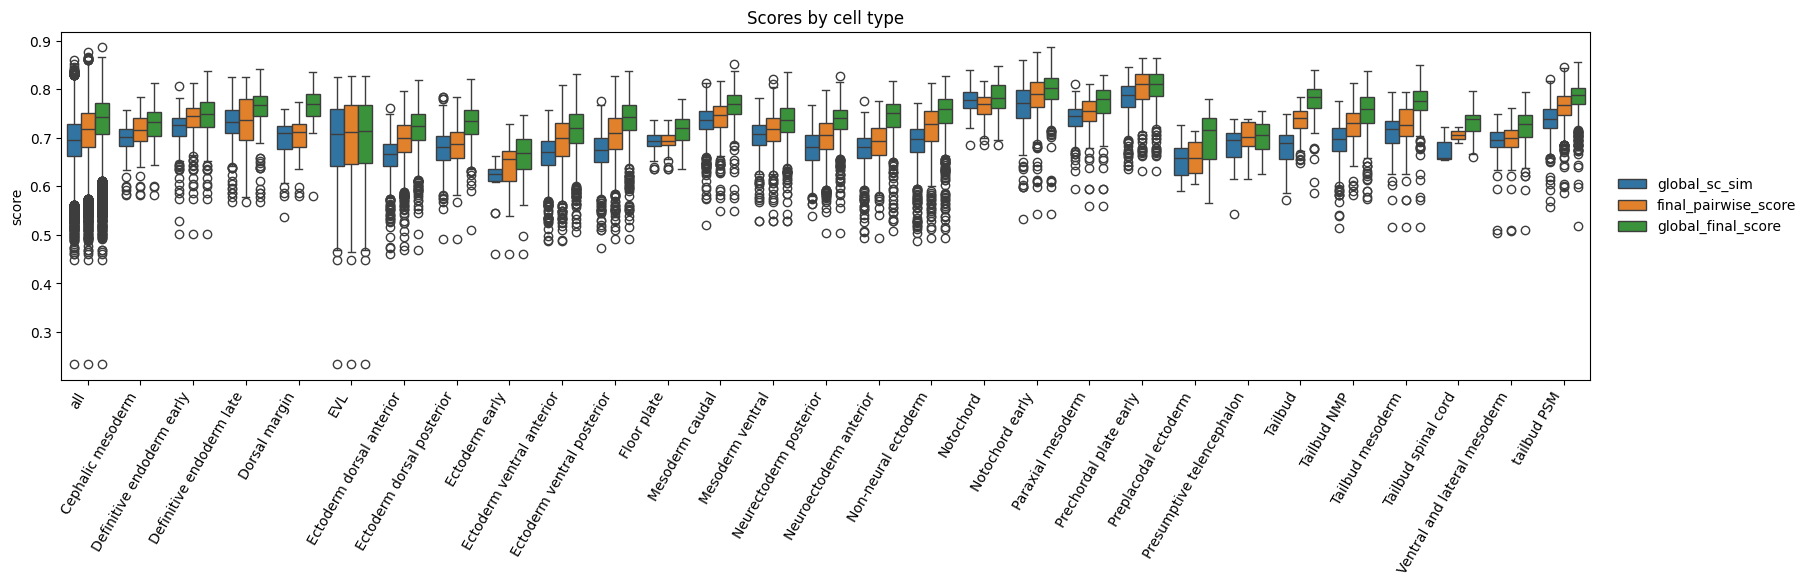

In [29]:
df_long, fig, ax = mapping_sc_to_st.fig.sim_score_box_plot(
    adata_st,
    pairs=[
        {"type_key": "global_sc_type", "score_key": "global_sc_sim", "label": "global_sc_sim"},
        {"type_key": "final_pairwise_type", "score_key": "final_pairwise_score", "label": "final_pairwise_score"},
        {"type_key": "global_final_type", "score_key": "global_final_score", "label": "global_final_score"},
    ],
    include_all=True,
    type_mode="intersection",
    figsize=(22, 6),
    rotate_xticks=60,
)


[plot_umap_with_category_colors] key='global_sc_type'
  n_obs=18019, n_categories=28
  missing in color_map: []
[plot_umap_with_category_colors] key='final_pairwise_type'
  n_obs=18019, n_categories=28
  missing in color_map: []
[plot_umap_with_category_colors] key='global_final_type'
  n_obs=18019, n_categories=30
  missing in color_map: []


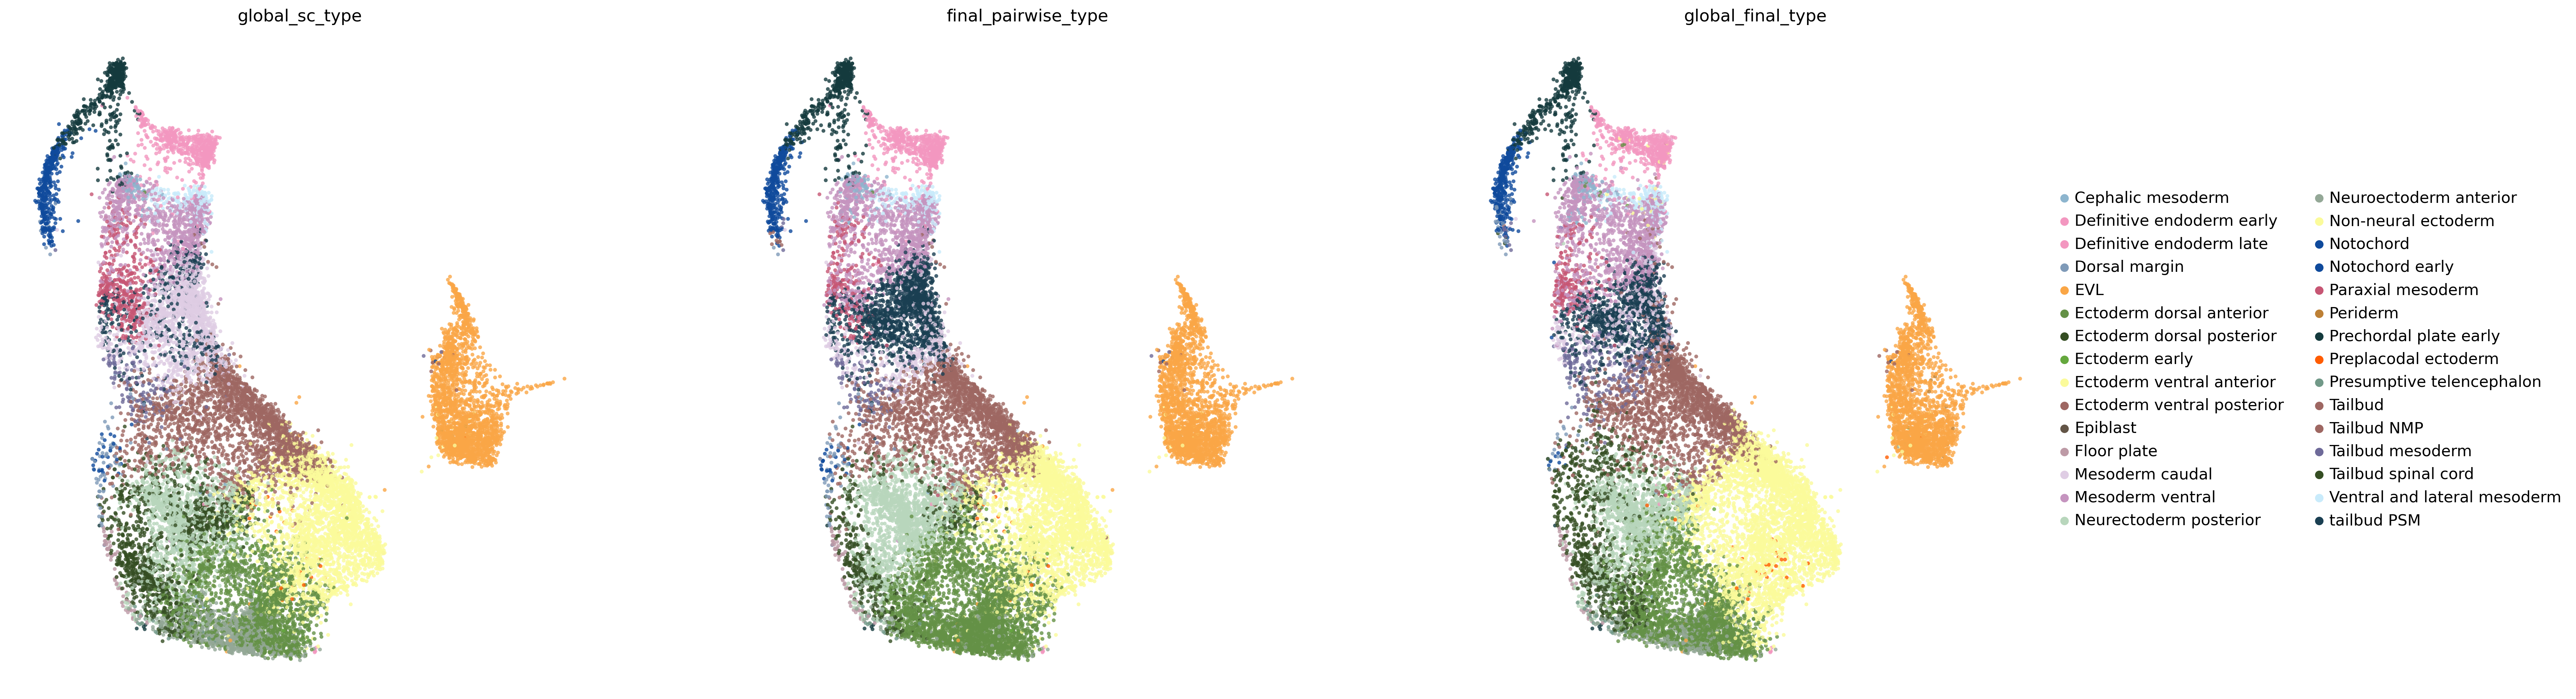

In [30]:
_ = mapping_sc_to_st.fig.plot_umap_st_cell_type(
    adata_st,
    cell_type_color=cell_type_color,
    keys=("global_sc_type","final_pairwise_type","global_final_type"),
    umap_kwargs_common=dict(size=40, alpha=0.8, legend_loc="right margin", frameon=False),
    fig_size=(30, 10),
)

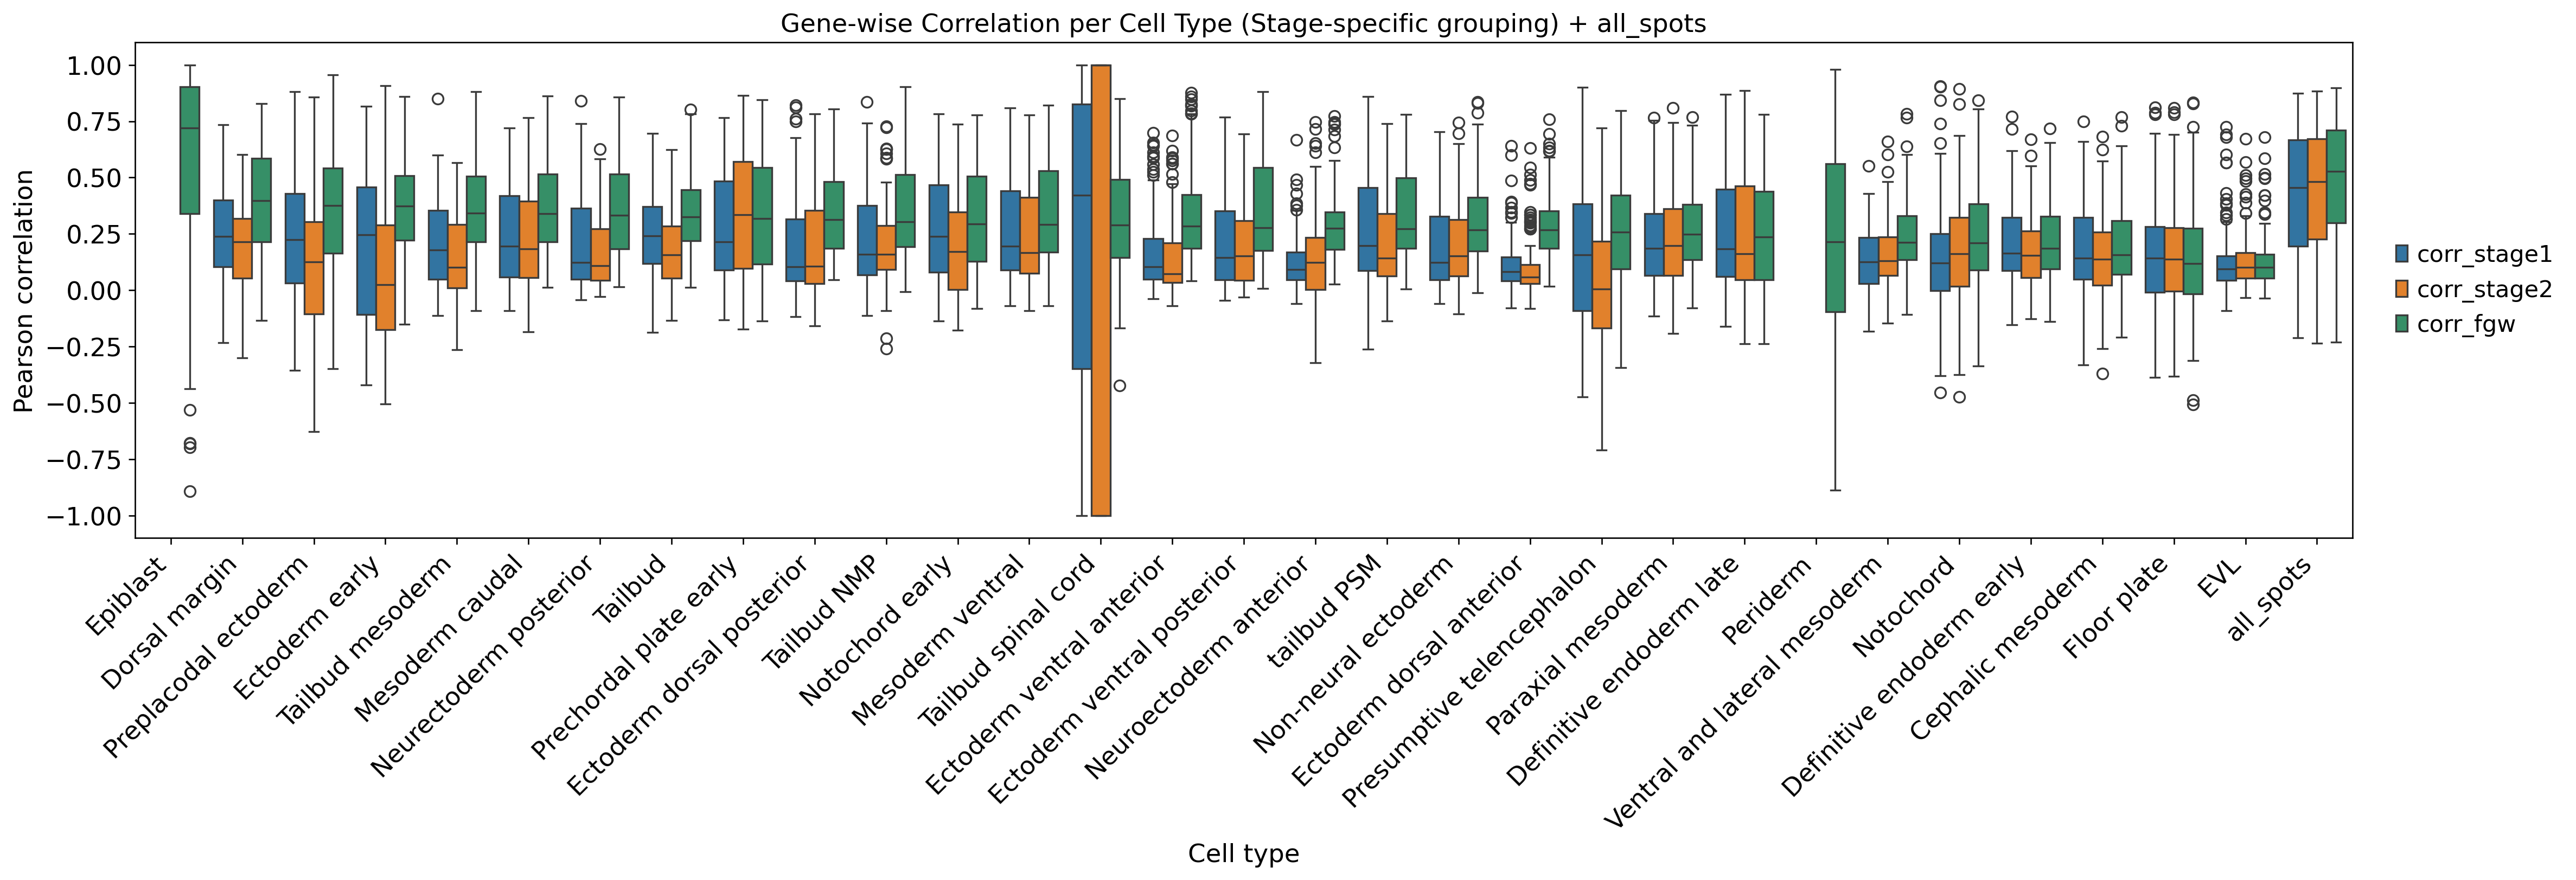

In [31]:
df_ct_stage, df_all = mapping_sc_to_st.gene_correlation.compute_ct_stage_specific_and_all_gene_corr(
    adata_sc=adata_sc,
    adata_st=adata_st,
    deg_results=out['deg_results'],
    bleeding_results=out['incoming_genes']['incoming_per_target'],
    min_spots=1,
    min_genes=1,
    min_n_corr=1,
)

fig, ax, df_used = mapping_sc_to_st.fig.plot_gene_wise_corr_stage_specific_boxplot(
    df_ct_stage=df_ct_stage,   # long (stage-specific)
    df_all_wide=df_all,        # wide (all_spots)
    include_all=True,
    all_labels=("all_spots", "all"),
)

## 2. Run LOO Corss Validation

In [15]:
df_corr, df_expr = mapping_sc_to_st.run_pipeline.run_loo(
    adata_sc_full=adata_sc,
    adata_st_full=adata_st_for_cv,
    cal_adata_st=adata_st,              
    full_gene_use_result=out,      
    df_all=df_all,  
    cfg=cfg,
    n_genes_sample = 445,
    seed=0,
    metacell_graph_path=metacell_graph,
    cell_type_color=cell_type_color,
    save_dir="/local/users/dlee/ST/result/LOO_CV/MC_SC_proposed_mapping",
    run_name="",
    min_spots_per_ct=1,
    save_each_gene=True, 
    verbose=True,
)

[run_loo] 410/445 genes done
[run_loo] 420/445 genes done
[run_loo] 430/445 genes done
[run_loo] 440/445 genes done
[run_loo] 445/445 genes done
[run_loo] saved: /local/users/dlee/ST/result/LOO_CV/MC_SC_proposed_mapping/_corr_excl_bleeding.pkl
[run_loo] saved: /local/users/dlee/ST/result/LOO_CV/MC_SC_proposed_mapping/_sc_st_expr_with_bleeding_flag.pkl
[run_loo] corr rows=40, expr rows=720760
